In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
#Import data
data = pd.read_csv(os.getcwd() + '/healthcare-dataset-stroke-data.csv')

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
data.dropna(inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.6+ KB


<h3>EDA</h3>

We will plot the variables and check the general behaviour of them related to strokes.

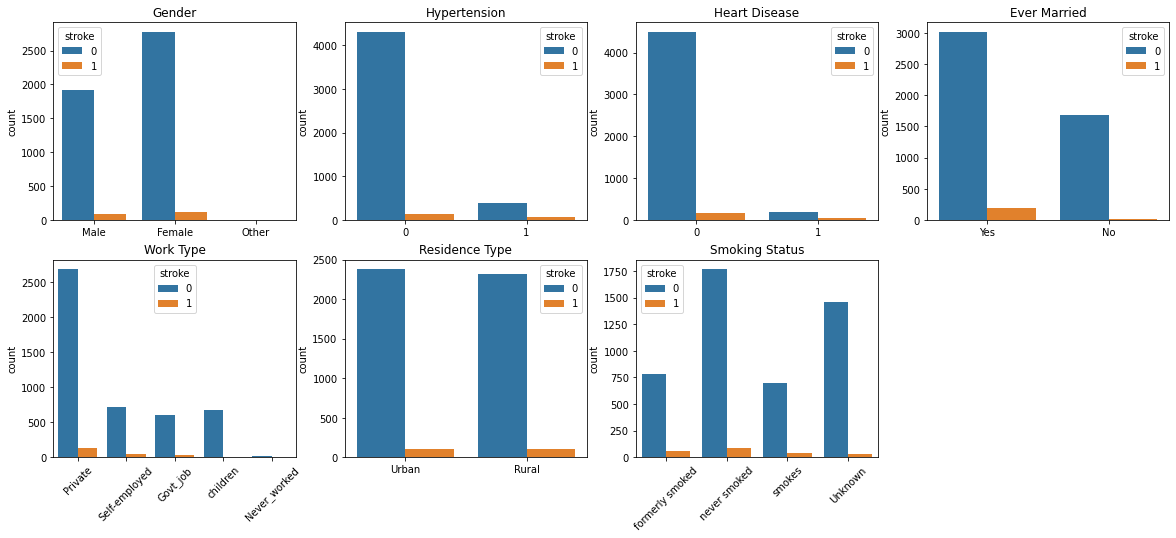

In [7]:
figure,ax = plt.subplots(2,4, figsize = (20,8))
sns.countplot(data = data, x = 'gender', hue = 'stroke', ax = ax[0,0]).set(title = 'Gender', xlabel = '')
sns.countplot(data = data, x = 'hypertension', hue = 'stroke', ax = ax[0,1]).set(title = 'Hypertension', xlabel = '')
sns.countplot(data = data, x = 'heart_disease', hue = 'stroke', ax = ax[0,2]).set(title = 'Heart Disease', xlabel = '')
sns.countplot(data = data, x = 'ever_married', hue = 'stroke', ax = ax[0,3]).set(title = 'Ever Married', xlabel = '')
sns.countplot(data = data, x = 'work_type', hue = 'stroke', ax = ax[1,0]).set(title = 'Work Type', xlabel = '')
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 45)
sns.countplot(data = data, x = 'Residence_type', hue = 'stroke', ax = ax[1,1]).set(title = 'Residence Type', xlabel = '')
sns.countplot(data = data, x = 'smoking_status', hue = 'stroke', ax = ax[1,2]).set(title = 'Smoking Status', xlabel = '')
ax[1,2].set_xticklabels(ax[1,2].get_xticklabels(),rotation = 45)
figure.delaxes(ax=ax[1,3])
plt.show()

<AxesSubplot:xlabel='bmi', ylabel='Count'>

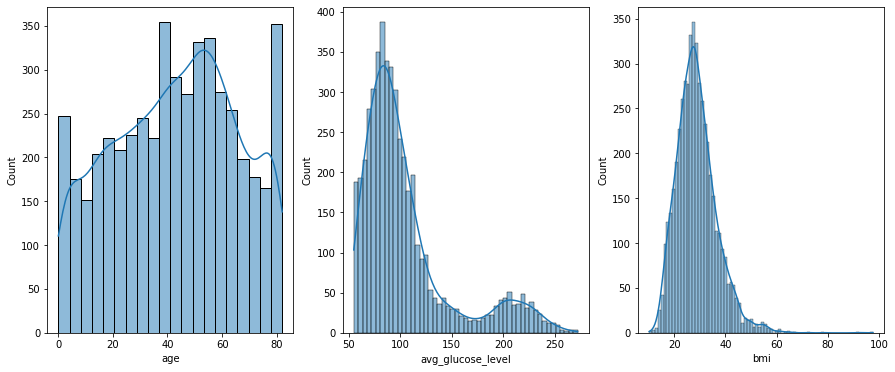

In [8]:
figure,ax = plt.subplots(1,3, figsize = (15,6))
sns.histplot(data['age'],  kde = True, ax = ax[0])
sns.histplot(data['avg_glucose_level'],  kde = True, ax = ax[1])
sns.histplot(data['bmi'],  kde = True, ax = ax[2])

[Text(0.5, 1.0, 'BMI'), Text(0.5, 0, '')]

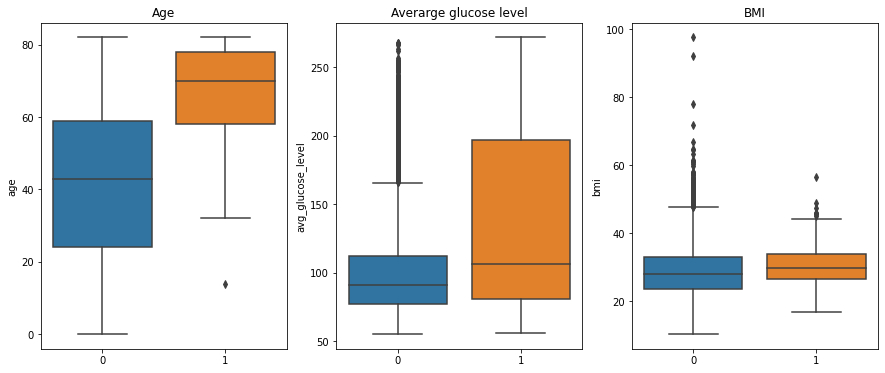

In [9]:
figure,ax = plt.subplots(1,3, figsize = (15,6))
sns.boxplot(data = data, y = 'age', x = 'stroke',ax = ax[0]).set(title = 'Age', xlabel = '')
sns.boxplot(data = data, y = 'avg_glucose_level', x = 'stroke', ax = ax[1]).set(title = 'Averarge glucose level', xlabel = '')
sns.boxplot(data = data, y = 'bmi', x = 'stroke', ax = ax[2]).set(title = 'BMI', xlabel = '')

We can see that the median age of people who have a stroke is a bit higher than the ones who dont. At the same time, the median of the BMI is very similar between the two, although, there are a lot of outliers in higher BMIs for people who haven't had a stroke. On the other hand people who have had a stroke usually have higher glucose levels.


<AxesSubplot:>

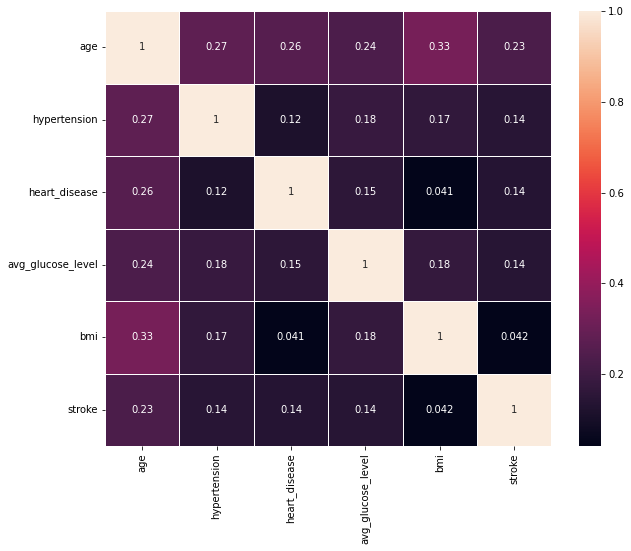

In [10]:
plt.figure(figsize = (10,8))
sns.heatmap(data.drop('id', axis = 1).corr(), annot = True, linewidths = 1)

There isn't big correlation between the variables.

<h3>Preprocessing</h3>


We can see that BMIs higher than 50 are actually quite rare, and can be pictured as outliers in the data, so we'll remove the BMIs over this value.

In [11]:
data = data[data['bmi']<50]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4830 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4830 non-null   int64  
 1   gender             4830 non-null   object 
 2   age                4830 non-null   float64
 3   hypertension       4830 non-null   int64  
 4   heart_disease      4830 non-null   int64  
 5   ever_married       4830 non-null   object 
 6   work_type          4830 non-null   object 
 7   Residence_type     4830 non-null   object 
 8   avg_glucose_level  4830 non-null   float64
 9   bmi                4830 non-null   float64
 10  smoking_status     4830 non-null   object 
 11  stroke             4830 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 490.5+ KB


We lost almost 100 observations in the previous process.

We will now scale and split the data set for train and test

<h3>Oversampling</h3>

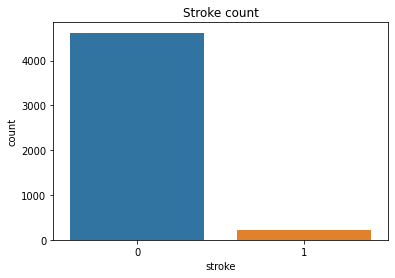

In [13]:
plt.figure()
sns.countplot(x = 'stroke', data = data)
plt.title('Stroke count')
plt.show()

As we don't have a lot of data with confirmed stroke, we will oversample the data we have. We will use the SMOTE method. Before that we need to get the dummies for the categorical variables, so we can later fit the model.

In [14]:
data = pd.get_dummies(data)

In [15]:
X = data.drop(['stroke', 'id'],axis = 1)
y = data['stroke']

In [16]:
smote = SMOTE(random_state=123)
X_sm , y_sm = smote.fit_resample(X,y)

With the oversampled data, we proceed to scale the continuous variables so that we can perform some categorical classification with the dataset. We use the Standard Scaler, that works just with the mean and standard deviation.

In [17]:
scaler = StandardScaler()
X_sm[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(X_sm[['age', 'avg_glucose_level', 'bmi']])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.3, random_state = 123)

In [19]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

<h3>SVM</h3>

To use the sopport vector classification, we can find the best values for C (cost) and Gamma. This values calibrate a margin of acceptance for the classification and the influence of each ovservation on it's radius. The Grid Search can help us find the best fitting avlues for the dataset.

In [20]:
param_grid = {'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.955 total time=   1.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   1.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.954 total time=   1.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.944 total time=   1.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.946 total time=   1.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.951 total time=   0.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.955 total time=   0.6s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.944 total time=   0.6s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.947 total time=   0.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.947 total time=   0.6s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.896 total time=   1.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=3)

In [21]:
grid.best_estimator_

SVC(C=1, gamma=1)

In [22]:
predicted_values = grid.predict(X_test)

In [23]:
print(classification_report(y_test.tolist(), predicted_values))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1407
           1       0.99      0.96      0.97      1367

    accuracy                           0.97      2774
   macro avg       0.98      0.97      0.97      2774
weighted avg       0.97      0.97      0.97      2774



In [24]:
print(confusion_matrix(y_test, predicted_values))

[[1393   14]
 [  57 1310]]


The classification report shows very high accuracy when predicting both strokes and not strokes (97%). We could compare this result with other methodologies like Trees, RandomFores or Boosting.

<h3>Random Forest</h3>

In [25]:
rfc = RandomForestClassifier(n_estimators = 400, max_depth = 7, bootstrap = True, oob_score = 0.8)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=400, oob_score=0.8)

In [26]:
predicted_rfc = rfc.predict(X_test)

In [27]:
print(classification_report(y_test.tolist(), predicted_rfc))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1407
           1       0.93      0.97      0.95      1367

    accuracy                           0.95      2774
   macro avg       0.95      0.95      0.95      2774
weighted avg       0.95      0.95      0.95      2774



In [28]:
print(confusion_matrix(y_test, predicted_rfc))

[[1306  101]
 [  46 1321]]


The accuracy is a little lower for the RF model compared to the SVM, although the approach shows still very good precision and recall for the prediction.

<h3>XGBoosting</h3>

In [31]:
data_matrix = xgb.DMatrix(data = X, label = y)

In [49]:
xgb_class = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 20, max_depth = 5)
xgb_class.fit(X_train, y_train)
predicted_xgb = xgb_class.predict(X_test)

In [50]:
print(classification_report(y_test.tolist(), predicted_xgb))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1407
           1       0.99      0.96      0.97      1367

    accuracy                           0.97      2774
   macro avg       0.97      0.97      0.97      2774
weighted avg       0.97      0.97      0.97      2774



With XGBoosting we get the same accuracy, but we increase the precision in the identification process of positive cases, which was the main goal of this notebook.